In [1]:
import numpy.random as npr

import jax
import jax.numpy as jnp 
import jax.random as jrnd
from jaxutils import Dataset

import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [26]:
# Imports from our code base
from elliptical_slice_sampler_jax import elliptical_slice_jax
from active_search import get_next_y, get_next_candidate_baseline
from plotting import plot_candidate, plot_eig
from gp_model import update_model, make_preds
from search_no_gpjax import generate_true_function, sample_from_posterior

# Generate data

In [143]:
n_grid = 10

nx, ny = (n_grid, n_grid)
x = jnp.linspace(0, 1, nx)
y = jnp.linspace(0, 1, ny)
xv, yv = jnp.meshgrid(x, y)
train_x = jnp.array([xv.flatten(),yv.flatten()]).T
# filter out things that are greater than 1
design_space = train_x[train_x.sum(1) <= 1]
pts = []
for x in design_space:
    pts.append(jnp.array([x[0], x[1], 1-x.sum()]))
    
knot_N = len(design_space)

In [144]:
npr.seed(10)

true_y, true_envelope = generate_true_function(design_space, knot_N)

tights = (true_y - true_envelope) <= 1e-3
tight_designs = design_space[tights.ravel(),:]
tight_pts = []
for x in tight_designs:
    tight_pts.append(jnp.array([x[0], x[1], 1-x.sum()]))
    
    
# Set random seed
#npr.seed(2)
rng_key = jrnd.PRNGKey(1)

num_iters = 1
design_inds = jnp.array(range(knot_N))

# observations
train_x = jnp.array([design_space[0], design_space[-1]])
train_y = jnp.array([true_y[0], true_y[-1]])
data = (train_x, train_y)

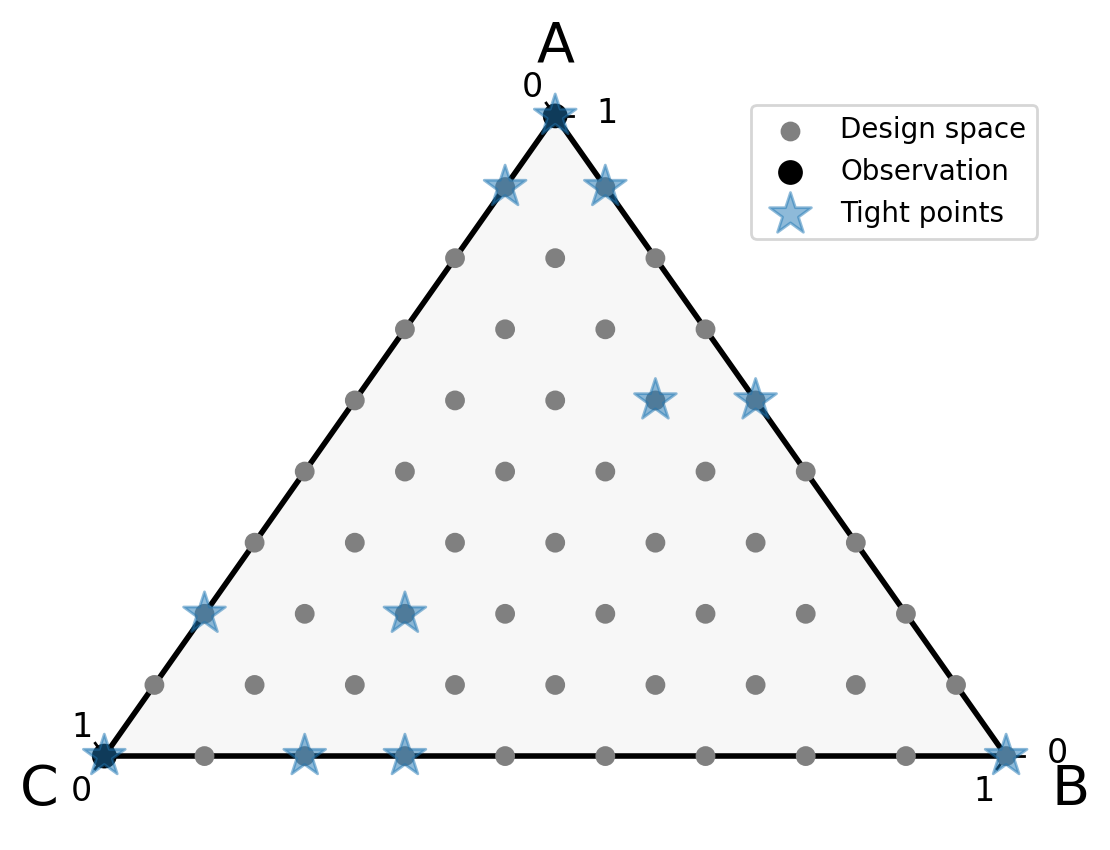

In [145]:
plot_triangle(pts, tight_pts, data, next_x = None, plot_design=True)

In [84]:
import ternary

def plot_triangle(pts, tight_pts, data, next_x = None, plot_design = True):
    fontsize=20
    ### Scatter Plot
    scale = 1
    figure, tax = ternary.figure(scale=scale)
    #tax.set_title("", fontsize=20)
    tax.boundary(linewidth=2.0)
    #tax.gridlines(multiple=1, color="blue")
    
    x_train_pts = []
    for x in data[0]:
        x_train_pts.append((x[0], x[1], 1-x.sum()))

    if plot_design:
        tax.scatter(pts, marker=".", label="Design space",  sizes=jnp.ones(len(pts))*150, c="gray", zorder=3)
    tax.scatter(x_train_pts, marker=".", label="Observation", sizes=jnp.ones(len(pts))*250, zorder=3, c="k")
    tax.scatter(tight_pts, marker="*", label="Tight points", sizes=jnp.ones(len(pts))*250, zorder=5, c="tab:blue", alpha=0.5)
    
    if next_x != None:
        tax.scatter([pts[next_x]], marker="*", label="Candidate", sizes=jnp.ones(len(pts))*250, zorder=6, c="tab:red")

    tax.legend(loc="upper right")
    tax.right_corner_label("B", fontsize=fontsize)
    tax.top_corner_label("A", fontsize=fontsize)
    tax.left_corner_label("C", fontsize=fontsize)
    tax.get_axes().axis('off')
    tax.clear_matplotlib_ticks()
    tax.ticks(axis='lbr', linewidth=1, multiple=1, offset=0.02, fontsize=12)
    tax.show()

In [85]:
# Suppose we start out by observing the two end points
#train_x = jnp.array([design_space[0], design_space[-1]]); train_y = jnp.array([true_y[0], true_y[-1]])
dataset = Dataset(X=train_x, y=train_y[:,jnp.newaxis])
designs = design_space[1:-1]

# Update the model given the data above
pred_mean, pred_cov, posterior, params = update_model(dataset, design_space, rng_key, update_params=False)

In [151]:
jnp.array(tight_pts)

Array([[0.        , 0.        , 1.        ],
       [0.22222222, 0.        , 0.77777778],
       [0.33333333, 0.        , 0.66666667],
       [1.        , 0.        , 0.        ],
       [0.        , 0.22222222, 0.77777778],
       [0.22222222, 0.22222222, 0.55555556],
       [0.33333333, 0.55555556, 0.11111111],
       [0.44444444, 0.55555556, 0.        ],
       [0.        , 0.88888889, 0.11111111],
       [0.11111111, 0.88888889, 0.        ],
       [0.        , 1.        , 0.        ]], dtype=float64)

In [70]:
make_preds(dataset, posterior, params, design_space[0:1], verbose=False)[1].ravel()[0]

Array(1.999999e-06, dtype=float64)

In [181]:
def plot_std(posterior, dataset, params, pts, next_x=None, scale=10, tight_pts=None, plot_design=False):
    
    """
    Scale: how finely to visualize the standard deviation.
    """
    
    figure, ax = plt.subplots(figsize=(8, 5))
    tax = ternary.TernaryAxesSubplot(ax=ax, scale=scale)

    def get_std(x):  
        test_x = jnp.array(x[0:2])
        var = make_preds(dataset, posterior, params, jnp.atleast_2d(test_x), verbose=False)[1].ravel()[0]
        std = jnp.sqrt(var)
        return std

    fontsize = 20
    ### Scatter Plot
    #figure, tax = ternary.figure(scale=scale)
    #tax.set_title("", fontsize=20)
    tax.boundary(linewidth=2.0)
    #tax.gridlines(multiple=n_grid, color="blue")

    if tight_pts != None:
        tax.scatter(jnp.array(tight_pts) * scale, marker="o", label="Tight points", 
                    sizes=jnp.ones(len(pts))*150, zorder=4, c="tab:purple", alpha=0.7)
        
    # plot observed data
    x_train_pts = []
    for x in dataset.X:
        x_train_pts.append((x[0] * scale, x[1] * scale, (1-x.sum()) * scale))
    tax.scatter(x_train_pts, marker=".", label="Observation", sizes=jnp.ones(len(pts))*250, zorder=5, c="k")

    if plot_design:
        tax.scatter(pts, marker=".", label="Design space",  sizes=jnp.ones(len(pts))*150, c="gray", zorder=3)
    
    # plot standard deviation
    tax.heatmapf(get_std, style="t", cmap=plt.cm.magma)
    
    # plot candidate design
    if next_x != None:
        #print(pts[next_x])
        tax.scatter([jnp.array(pts[next_x]) * scale], marker="*", label="Candidate design", 
                    sizes=jnp.ones(len(pts))*200, zorder=6, c="tab:red", edgecolors="k")

    
    tax.clear_matplotlib_ticks()
    tax.legend(loc="upper right")
    tax.right_corner_label("B", fontsize=fontsize)
    tax.top_corner_label("A", fontsize=fontsize)
    tax.left_corner_label("C", fontsize=fontsize)
    tax.get_axes().axis('off')

    #tax.ticks(axis='lbr', linewidth=1, multiple=1, offset=0.02, fontsize=12)
    tax.show()
    

# Baseline: no convex hull information

Iteration:  0
(Array([[0., 0.],
       [0., 1.]], dtype=float64), Array([1.33158651, 0.32538117], dtype=float64))
CPU times: user 845 ms, sys: 3.97 ms, total: 849 ms
Wall time: 847 ms
[0.77777778 0.22222222] [-5.15393414e-01 -8.77921111e-02 -3.87083470e-03 -4.88665997e-05
  2.30141968e-06  2.49977039e-06  2.49999368e-06  2.49999375e-06
  2.49999375e-06 -5.15393414e-01 -6.23623343e+00  1.91688192e-01
  4.88074394e-01  5.18889682e-01  5.20241768e-01  5.20259845e-01
  5.20259915e-01  5.20259915e-01 -8.77921111e-02  1.91688192e-01
 -6.21462081e+00  2.44328695e-01  5.18974160e-01  5.47996845e-01
  5.49272566e-01  5.49289623e-01 -3.87083470e-03  4.88074394e-01
  2.44328695e-01 -6.21460797e+00  2.44360103e-01  5.18992352e-01
  5.48014012e-01 -4.88665997e-05  5.18889682e-01  5.18974160e-01
  2.44360103e-01 -6.21460797e+00  2.44360103e-01  2.30141968e-06
  5.20241768e-01  5.47996845e-01  5.18992352e-01  2.44360103e-01
  2.49977039e-06  5.20259845e-01  5.49272566e-01  5.48014012e-01
  2.49999368

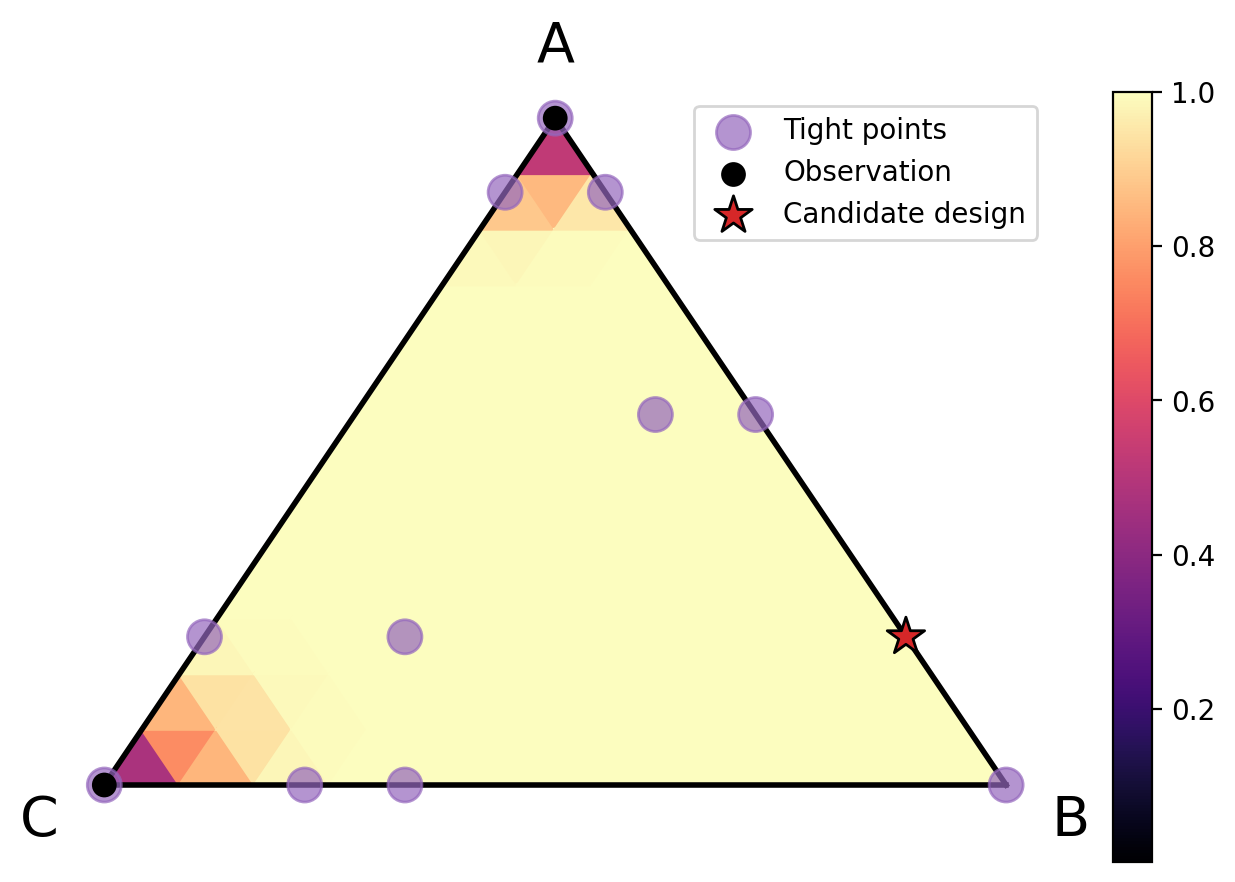

In [184]:
## baseline

num_iters = 1

# Note 2/20: something isn't right here
# TODO: need to make sure predictions have the right shape

for i in range(num_iters):
    
    print("Iteration: ", i)    
    print(data)
    %time next_x, entropy_change = get_next_candidate_baseline(posterior, params, dataset, designs, design_space)
    
    print(next_x, entropy_change)
    next_x_ind = (design_space == next_x).sum(1).argmax()
    #plot_triangle(pts, tight_pts, data, next_x_ind, plot_design=False) 

    # plot posterior std
    plot_std(posterior, dataset, params, pts, next_x_ind, tight_pts=tight_pts, scale=12)
    
    #dataset = dataset + Dataset(X=jnp.atleast_2d(next_x), y=jnp.atleast_2d(true_y[next_x_ind]))
    #designs = jnp.delete(designs, (designs == next_x).argmax())[:, jnp.newaxis]
    
    #pred_mean, pred_cov, posterior, params = update_model(dataset, design_space, rng_key, update_params=False)

# TODO:

Next steps:
* Finish the data set processing
* Check the shapes for the data / predictive distribution